In [2]:
from matplotlib import pyplot as plt

from torch.utils.data import DataLoader
import torch.nn.functional as F

from gelgenie.segmentation.networks.UNets.model_gateway import smp_UNet, smp_UNetPlusPlus
from gelgenie.segmentation.data_handling.dataloaders import ImageDataset

import numpy as np
import torch
from skimage.color import label2rgb

import torch.onnx
import onnx
import onnxruntime
import cv2
from onnxsim import simplify



In [3]:

nets = []

checkpoint_file_paths = ["/Users/matt/Documents/PhD/research_output/Automatic_Gel_Analyzer/segmentation_models/smp-UNet_No_Augmentations/checkpoints/checkpoint_epoch390.pth",
                         '/Users/matt/Documents/PhD/research_output/Automatic_Gel_Analyzer/segmentation_models/smp_unet++_july28_nathan/checkpoints/checkpoint_epoch_504.pth']
n_channels = 1

def load_model(checkpoint):
    net = smp_UNet(
                encoder_name="resnet18",  # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
                in_channels=1,  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
                classes=2,  # model output channels (number of classes in your dataset)
            )
    net = smp_UNetPlusPlus(
                encoder_name="resnet18",  # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
                in_channels=1,  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
                classes=2,  # model output channels (number of classes in your dataset)
            )
    net.eval()
    saved_dict = torch.load(f=checkpoint, map_location=torch.device("cpu"))
    net.load_state_dict(saved_dict['network'])
    print(f'Model loaded from {checkpoint}')
    return net


net = load_model(checkpoint_file_paths[1])

image_dir = '/Users/matt/Documents/PhD/research_output/Automatic_Gel_Analyzer/data/processed_gels/dummy_set/images_train'
val_set = ImageDataset(image_dir, n_channels, padding=True)

dataloader = DataLoader(val_set, shuffle=False, batch_size=1, num_workers=1, pin_memory=True)


Model loaded from /Users/matt/Documents/PhD/research_output/Automatic_Gel_Analyzer/segmentation_models/smp_unet++_july28_nathan/checkpoints/checkpoint_epoch_504.pth


Padding images to 1376x1376

Created dataset with 2 images.

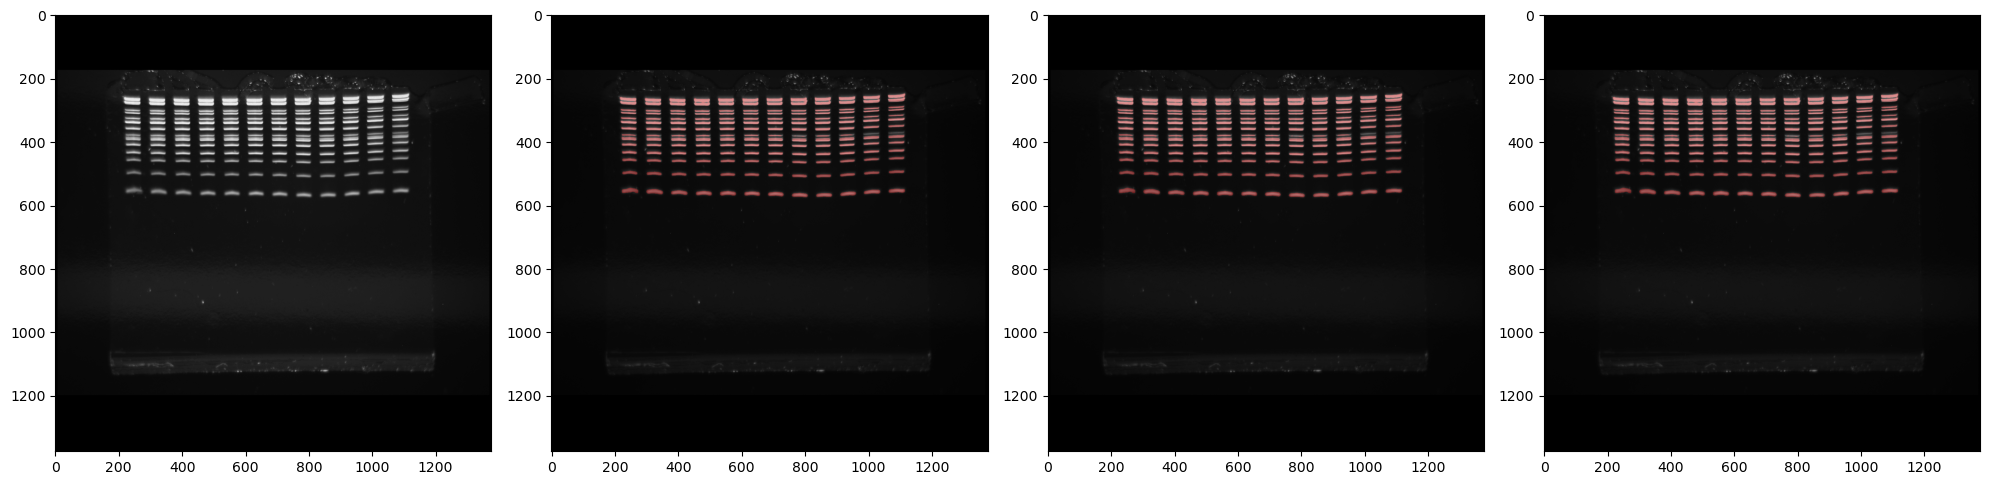

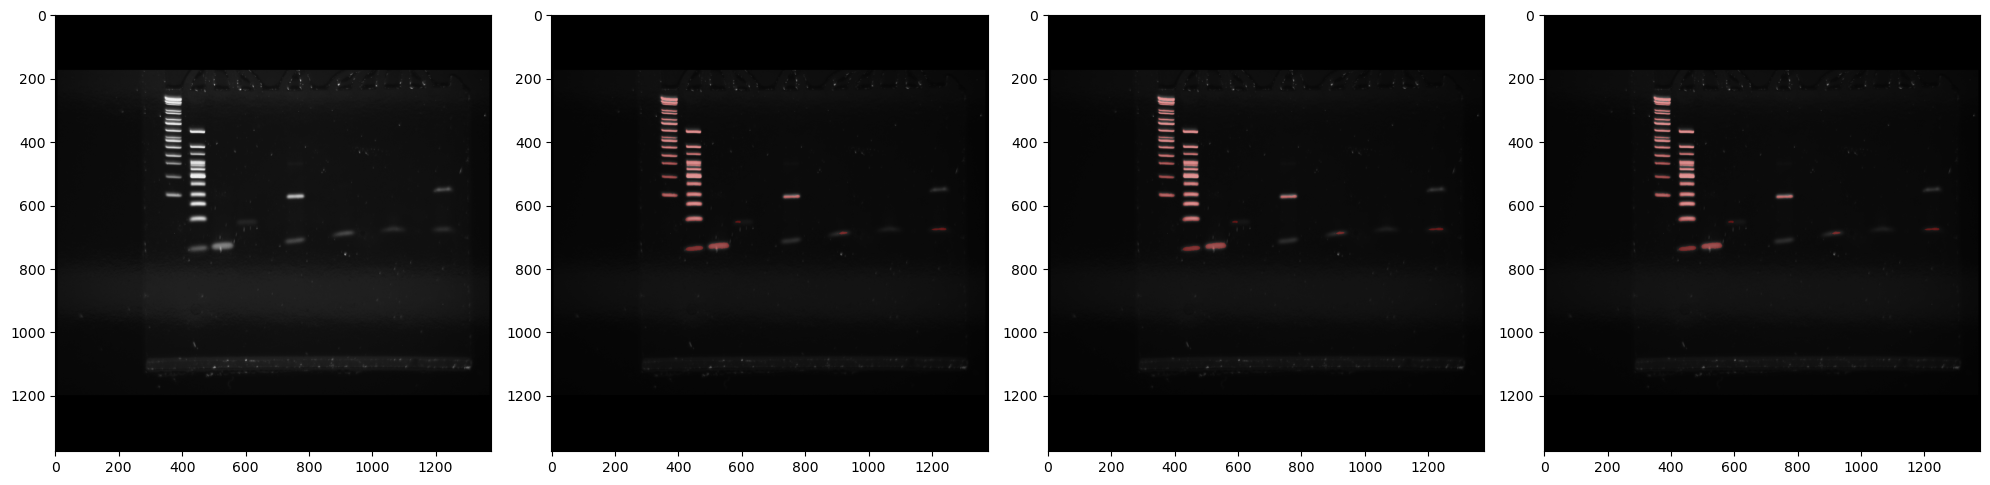

In [15]:

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

ort_session = onnxruntime.InferenceSession("/Users/matt/Desktop/unet_trial_4-sim.onnx")

cv_net = cv2.dnn.readNet('/Users/matt/Desktop/unet_trial_4-sim.onnx')

for im_index, batch in enumerate(dataloader):

    fig, ax = plt.subplots(1,4, figsize=(20,10))

    original_image = batch['image'].squeeze().detach().squeeze().cpu().numpy()

    with torch.no_grad():
        mask_pred = net(batch['image'])

    # compute ONNX Runtime output prediction
    ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(batch['image'])}
    ort_outs = ort_session.run(None, ort_inputs)

    # compute CV2 image
    cv_net.setInput(to_numpy(batch['image']))
    cv_out = cv_net.forward()

    one_hot = F.one_hot(mask_pred.argmax(dim=1), 2).permute(0, 3, 1, 2).float()
    onn = one_hot.numpy().squeeze()

    onnx_out = F.one_hot(torch.from_numpy(ort_outs[0]).argmax(dim=1), 2).permute(0, 3, 1, 2).float()
    onnx_out = onnx_out.numpy().squeeze()

    cv_out = F.one_hot(torch.from_numpy(cv_out).argmax(dim=1), 2).permute(0, 3, 1, 2).float()
    cv_out = cv_out.numpy().squeeze()

    model_onnx_labels = label2rgb(onnx_out.argmax(axis=0), image=original_image)

    model_direct_labels = label2rgb(onn.argmax(axis=0), image=original_image)

    cv_labels = label2rgb(cv_out.argmax(axis=0), image=original_image)

    ax[0].imshow(original_image, cmap='gray')
    ax[1].imshow(model_direct_labels)
    ax[2].imshow(model_onnx_labels)
    ax[3].imshow(cv_labels)
    plt.tight_layout()



In [7]:
# ONNX MODEL CREATION
net.eval()

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()


for im_index, batch in enumerate(dataloader):
    torch_out = net(batch['image'])
    break

# Export the model
torch.onnx.export(net,               # model being run
                  batch['image'],                         # model input (or a tuple for multiple inputs)
                  "/Users/matt/Desktop/unet_trial_2.onnx",   # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=12,          # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['input'],   # the model's input names
                  output_names = ['output'])

# Export the model
# torch.onnx.export(net,               # model being run
#                   batch['image'],                         # model input (or a tuple for multiple inputs)
#                   "/Users/matt/Desktop/unet_trial_2.onnx",   # where to save the model (can be a file or file-like object)
#                   export_params=True,        # store the trained parameter weights inside the model file
#                   opset_version=12,          # the ONNX version to export the model to
#                   do_constant_folding=True,  # whether to execute constant folding for optimization
#                   input_names = ['input'],   # the model's input names
#                   output_names = ['output'], # the model's output names
#                   dynamic_axes={'input' : {0 : 'batch_size', 2: 'height', 3: 'width'},    # variable length axes
#                                 'output' : {0 : 'batch_size', 2: 'height', 3: 'width'}})

onnx_model = onnx.load("/Users/matt/Desktop/unet_trial_2.onnx")
onnx.checker.check_model(onnx_model)

ort_session = onnxruntime.InferenceSession("/Users/matt/Desktop/unet_trial_2.onnx")

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

# compute ONNX Runtime output prediction
ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(batch['image'])}
ort_outs = ort_session.run(None, ort_inputs)

# compare ONNX Runtime and PyTorch results
np.testing.assert_allclose(to_numpy(torch_out), ort_outs[0], rtol=1e-03, atol=1e-05)

print("Exported model has been tested with ONNXRuntime, and the result looks good!")


/Users/matt/opt/anaconda3/envs/gel_segmentation/lib/python3.8/site-packages/segmentation_models_pytorch/base/model.py:16: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if h % output_stride != 0 or w % output_stride != 0:


AssertionError: 
Not equal to tolerance rtol=0.001, atol=1e-05

Mismatched elements: 2 / 3786752 (5.28e-05%)
Max absolute difference: 0.00014687
Max relative difference: 0.06587794
 x: array([[[[ 3.926303,  4.918604,  4.627107, ...,  5.719964,  5.838552,
           4.183955],
         [ 4.393462,  6.117072,  6.060731, ...,  6.736036,  7.101276,...
 y: array([[[[ 3.926303,  4.918605,  4.627108, ...,  5.719964,  5.838552,
           4.183955],
         [ 4.393462,  6.117074,  6.060732, ...,  6.736038,  7.101276,...

In [12]:
# Export the model
torch.onnx.export(net,  # model being run
                  batch['image'],  # model input (or a tuple for multiple inputs)
                  "/Users/matt/Desktop/unet_trial_4.onnx",
                  # where to save the model (can be a file or file-like object)
                  export_params=True,  # store the trained parameter weights inside the model file
                  opset_version=12,  # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names=['input'],  # the model's input names
                  output_names=['output'],
                  dynamic_axes={'input': {0: 'batch_size', 2: 'height', 3: 'width'},  # variable length axes
                                'output': {0: 'batch_size', 2: 'height', 3: 'width'}})


In [13]:
import cv2

cv_net = cv2.dnn.readNet('/Users/matt/Desktop/unet_trial_3-sim.onnx')


In [6]:
np_im = to_numpy(batch['image'])


In [8]:
cv_net.setInput(np_im)
out = cv_net.forward()
out.shape


(1, 2, 1376, 1376)

In [14]:
import onnx
from onnxsim import simplify

# load your predefined ONNX model
model = onnx.load("/Users/matt/Desktop/unet_trial_4.onnx")

# convert model
model_simp, check = simplify(model)

assert check, "Simplified ONNX model could not be validated"

onnx.save(model_simp, "/Users/matt/Desktop/unet_trial_4-sim.onnx")


### Tests for opencv 4.7

In [4]:
for im_index, batch in enumerate(dataloader):
    with torch.no_grad():
        mask_pred = net(batch['image'])
        break


In [17]:
batch['image'].shape

torch.Size([1, 1, 1376, 1376])

In [13]:
model_name = 'test_u++'
# Export the model
torch.onnx.export(net,  # model being run
                  batch['image'],  # model input (or a tuple for multiple inputs)
                  "/Users/matt/Desktop/%s.onnx" % model_name,
                  # where to save the model (can be a file or file-like object)
                  export_params=True,  # store the trained parameter weights inside the model file
                  opset_version=11,  # the ONNX version to export the model to
                  do_constant_folding=False,  # whether to execute constant folding for optimization
                  input_names=['input'],  # the model's input names
                  output_names=['output'],
                  dynamic_axes={'input': {2: 'height', 3: 'width'},  # variable length axes
                                'output': {2: 'height', 3: 'width'}})

onnx_model = onnx.load("/Users/matt/Desktop/%s.onnx" % model_name)
onnx.checker.check_model(onnx_model)

model_simp, check = simplify(onnx_model)

assert check, "Simplified ONNX model could not be validated"

onnx.save(model_simp, "/Users/matt/Desktop/%s-sim.onnx" % model_name)
cv_net = cv2.dnn.readNet("/Users/matt/Desktop/%s-sim.onnx" % model_name)

================ Diagnostic Run torch.onnx.export version 2.0.1 ================
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



In [16]:
model_name = 'test_u++'
# cv_net = cv2.dnn.readNet("/Users/matt/Documents/PhD/research_output/Automatic_Gel_Analyzer/data/QuPath Gel Labelling Project/u++_132_james-sim.onnx")

cv_net = cv2.dnn.readNet("/Users/matt/Desktop/%s-sim.onnx" % model_name)


In [8]:
batch['image'].shape

torch.Size([1, 1, 1376, 1376])

In [11]:
cv_net = cv2.dnn.readNet("/Users/matt/Desktop/modnet-mobilenetv2_orig.onnx")

[ERROR:0@2145.315] global onnx_importer.cpp:1064 handleNode DNN/ONNX: ERROR during processing node with 2 inputs and 1 outputs: [Concat]:(onnx_node!p2o.Concat.12) from domain='ai.onnx'


error: OpenCV(4.8.1) /Users/runner/work/opencv-python/opencv-python/opencv/modules/dnn/src/onnx/onnx_importer.cpp:1083: error: (-2:Unspecified error) in function 'handleNode'
> Node [Concat@ai.onnx]:(onnx_node!p2o.Concat.12) parse error: OpenCV(4.8.1) /Users/runner/work/opencv-python/opencv-python/opencv/modules/dnn/src/layers/concat_layer.cpp:109: error: (-201:Incorrect size of input array) Inconsistent shape for ConcatLayer in function 'getMemoryShapes'
> 